In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
import requests
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes, metrics
from operator import add
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet');

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# ECON 323 FINAL PROJECT: ANALYSIS CODE

In this notebook I am interested in looking at two main questions: first, can e-books be classified as bestsellers using review and blurb text elements, and second, can daily e-book sales be predicted using numeric attributes scraped from Amazon e-book listings.

This notebook uses the dataset created in the "Data_Collection" notebook, which should be read first.

## 1. Data Cleaning
The first step in the analysis process to to clean the dateset. The data that I scraped is not anywhere close to clean so there is a significant amount of work to do to make it useful.

### 1.1 Import Data
First I import all 5 datasets outputted from the scraping code, merge them into one data frame, and save the raw data locally for safe keeping. Looking at the raw dateset, the only variable that does not need work is the Book Name.

In [389]:
all_files = glob.glob( "scraped_data/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw_amazon_data = pd.concat(li, axis=0, ignore_index=True)

raw_amazon_data.to_csv('raw_amazon_data.csv', index=False, encoding='utf-8')

raw_amazon_data.head()

,Book Name,Author,Price,KU,Rankings,Rating,Customers_Rated,Blurb,Reviews_Ratings,Reviews_Titles,Reviews_Texts
0,TAGGED BY DEATH (RILEY MALLOY THRILLER SERIES...,['Judith A. Barrett'],CDN$ 6.99,1,"Best Sellers Rank: #6,162 in Kindle Store (...",4.0 out of 5 stars,71 ratings,\n Only the dog whisperer can identify a seri...,[],[],[]
1,The Armstrong Assignment (A Janet Markham Ben...,['Diana Xarissa'],CDN$ 3.99,1,"Best Sellers Rank: #1,736 in Kindle Store (...",4.6 out of 5 stars,316 ratings,\n Janet Markham’s wedding day is perfect in ...,"['5.0 out of 5 stars', '5.0 out of 5 stars']","['\nA New Adventure\n', '\nA lovely page turne...",['\n\n Janet and Edward are starting their li...
2,Overachiever (Slumming It Book 2),['S.M. Shade'],CDN$ 5.10,1,"Best Sellers Rank: #3,630 in Kindle Store (...",4.7 out of 5 stars,107 ratings,"\n ""Overachiever was hands down one of the be...","['5.0 out of 5 stars', '4.0 out of 5 stars', '...","['\nWow\n', '\nA laugh-out-loud college romanc...",['\n\n I cannot wait for the 3rd book in this...
3,The Perfect Couple: A gripping USA Today psyc...,['Jackie Kabler'],CDN$ 5.99,1,Best Sellers Rank: #1 in Kindle Store (See ...,4.1 out of 5 stars,"11,783 ratings",\n THE 2020 BESTSELLER!Perfect for fans of Li...,"['4.0 out of 5 stars', '2.0 out of 5 stars', '...","['\nsolid, kept me guessing\n', '\nTypical pre...","[""\n\n This is a plot driven story and it wor..."
4,Sold on a Monday: A Novel,['Kristina McMorris'],CDN$ 11.10,1,Best Sellers Rank: #2 in Kindle Store (See ...,4.2 out of 5 stars,"15,798 ratings",\n A NEW YORK TIMES BESTSELLER A USA TODAY BE...,"['5.0 out of 5 stars', '5.0 out of 5 stars', '...","['\nTruth bares fiction\n', '\nLoved it\n', '\...",['\n\n It is a bit of the reality of the time...


### 1.2 Clean Numeric Variables
I will start by cleaning all the numeric data. For each of these variables I need to remove any extraneous text the might have been scraped along with the number of interest and then convert the column into floats or integers. 

For the kindle store rankings, I run into additional issues. I scrapped all the rankings in both the overall kindle store and in specific genres as one string. I need to separate out just the kindle store rankings and get rid of all the other rankings. However, for unknown reasons some books did not have a kindle store ranking, only rankings in subgenres. For those book I want to give them a NA value.

In [390]:
df = pd.read_csv('raw_amazon_data.csv', index_col=None, header=0)

#define clean string function
def clean_str(x, r_text):
    if isinstance(x, str):
        return(x.replace(r_text, ''))
    return(x)

#convert price to float
df['Price'] = raw_amazon_data['Price'].apply(clean_str, args =("CDN$ ",)).astype(float)

#separate kindle store overall rankings from other rankings, where no overall kindle stroe ranking, set NaN
df['Rankings'] = df['Rankings'].astype(str)
df['Rankings'] = np.where(df['Rankings'].str.contains(" in Kindle Store", na=False),df['Rankings'], "NO KS RANK")
df['Rankings'] = df['Rankings'].apply(lambda x: x.split('#',1)[-1])
df['Rankings'] = df['Rankings'].apply(lambda x: x.split(' in Kindle Store')[0])

#convert ranking to float
df['Rankings'] = df['Rankings'].str.replace(",", "")
df['Rankings'] = df['Rankings'].replace("NO KS RANK", np.nan)
df['Rankings'] = df['Rankings'].replace("37 Free", np.nan)
df['Rankings'] = df['Rankings'].astype(float)

#convert rating to float
df['Rating'] = df['Rating'].apply(clean_str, args =(" out of 5 stars",)).astype(float)

#convert customers_rated to float
df['Customers_Rated'] = df['Customers_Rated'].apply(clean_str, args =(" ratings",))
df['Customers_Rated'] = df['Customers_Rated'].apply(clean_str, args =(" rating",))
df['Customers_Rated'] = df['Customers_Rated'].apply(clean_str, args =("[]",))
df['Customers_Rated'] = df['Customers_Rated'].replace("", np.nan)
df['Customers_Rated'] = df['Customers_Rated'].apply(clean_str, args =(",",)).astype(float)

### 1.3 Clean String Variables

We have two non-review related string variables, author and blurb. For the author variable I scraped all authors associated with each book and stored them in a list. Now I want to take the authors out of a list and format them nicely as a single string that lists all the authors. For the blurb varible I just remove the "\n"s.

In [391]:
#define function to format author(s)
def author_list(x):
    a = ''
    for i in range(0, len(x)):
        if i == 0:
            a = str(x[i])
        elif i != len(x) - 1:
            a += (" , " + str(x[i]))
        else:
            a += (" & " + str(x[i]))
    return a

#reformat author variable and convert to string
df['Author'] = df['Author'].apply(eval)
df['Author'] = df['Author'].apply(author_list).astype(str)

#reformat blurb variable
df['Blurb'] = df['Blurb'].apply(clean_str, args =("\n",)).astype(str)

### 1.4 Clean Review Variables
For the review variables, each variable is currently stored as a list with each element in the list corresponding to an individual review. For my analysis, I want to combine all the reviews into a big string so that we can tokenize them later. I do this for the text and title variables. For the rating varible I create a new variable average review ratings.

In [392]:
#Clean review ratings
df['Reviews_Ratings'] = df['Reviews_Ratings'].apply(eval)

df_reviews = df['Reviews_Ratings'].apply(pd.Series)
df_reviews = df_reviews.applymap(lambda x: clean_str(x, " out of 5 stars"))
df_reviews = df_reviews.astype(float)
df_reviews["Average_Review_Rating"] = df_reviews.mean(axis = 1, skipna=True)

df["Average_Review_Rating"] = df_reviews["Average_Review_Rating"]

In [393]:
#Clean review titles
df['Reviews_Titles'] = df['Reviews_Titles'].replace(np.nan, "[]")
df['Reviews_Titles'] = df['Reviews_Titles'].astype(str).apply(eval)
df_reviews_title = df['Reviews_Titles'].apply(pd.Series)
df_reviews_title = df_reviews_title.applymap(lambda x: clean_str(x, "\n"))
df_reviews_title = df_reviews_title.replace(np.nan, "")
df_reviews_title['All_Review_Titles'] = df_reviews_title.agg(' '.join, axis=1).str.strip()
df_reviews_title = df_reviews_title.replace("", np.nan)

df['All_Review_Titles'] = df_reviews_title['All_Review_Titles']

In [394]:
#Clean review text
df['Reviews_Texts'] = df['Reviews_Texts'].replace(np.nan, "[]")
df['Reviews_Texts'] = df['Reviews_Texts'].astype(str).apply(eval)

df_reviews_text = df['Reviews_Texts'].apply(pd.Series)
df_reviews_text = df_reviews_text.applymap(lambda x: clean_str(x, "\n"))
df_reviews_text = df_reviews_text.replace(np.nan, "")
df_reviews_text['All_Review_Text'] = df_reviews_text.agg(' '.join, axis=1).str.strip()
df_reviews_text = df_reviews_text.replace("", np.nan)

df['All_Review_Text'] = df_reviews_text['All_Review_Text']

### 1.5 Export Clean Data
Finally I drop extraneous columns and save the clean data as a csv.

In [395]:
df.drop(['Reviews_Ratings', 'Reviews_Texts', 'Reviews_Titles'], axis=1, inplace=True)
df.to_csv('clean_amazon_data.csv', index=False, encoding='utf-8')
df.head()

,Book Name,Author,Price,KU,Rankings,Rating,Customers_Rated,Blurb,Average_Review_Rating,All_Review_Titles,All_Review_Text
0,TAGGED BY DEATH (RILEY MALLOY THRILLER SERIES...,Judith A. Barrett,6.99,1,6162.0,4.0,71.0,Only the dog whisperer can identify a serial...,NaN,NaN,NaN
1,The Armstrong Assignment (A Janet Markham Ben...,Diana Xarissa,3.99,1,1736.0,4.6,316.0,Janet Markham’s wedding day is perfect in ev...,5.000000,A New Adventure A lovely page turner.,Janet and Edward are starting their life toget...
2,Overachiever (Slumming It Book 2),S.M. Shade,5.10,1,3630.0,4.7,107.0,"""Overachiever was hands down one of the best...",4.857143,Wow A laugh-out-loud college romance! Hilariou...,I cannot wait for the 3rd book in this series....
3,The Perfect Couple: A gripping USA Today psyc...,Jackie Kabler,5.99,1,1.0,4.1,11783.0,THE 2020 BESTSELLER!Perfect for fans of Lian...,2.750000,"solid, kept me guessing Typical predictable mo...",This is a plot driven story and it worked for ...
4,Sold on a Monday: A Novel,Kristina McMorris,11.10,1,2.0,4.2,15798.0,A NEW YORK TIMES BESTSELLER A USA TODAY BEST...,4.375000,Truth bares fiction Loved it OK story but not ...,It is a bit of the reality of the times. My o...


## 2. Predicting Bestsellers from Text
The first analysis activity I conduct is predicting bestsellers using text variables. My dataset has three main types of text, the blurb, the review titles, and the review content. I am going to try to use each of these individually to predict bestsellers and then use a 'bag of words' containing all the text I scraped. I test two different types of classification model (Naive Bayes and Support Vector).

### 2.1 Text Preprocessing 

Before I use the classification models, I need to preprocess my data. I start by importing my clean dataset and then removing rows where there are missing values in the variables of interest to me in this exercise.

In [397]:
df = pd.read_csv('clean_amazon_data.csv', index_col=None, header=0)
df = df[df['Rankings'].notna()]
df = df[df['All_Review_Text'].notna()]
df = df[df['All_Review_Titles'].notna()]
df = df[df['Blurb'].notna()]

df['Bestseller'] = df['Rankings'].apply(lambda x: 1 if x <= 100 else 0)

Then I follow the steps used in the QuantEcon textbook to clean, tokenize and remove stopwords from my text.

In [398]:
# Remove stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords=stopwords.union(set(string.punctuation))
additional_stopwords = ['\'s', '’', 'n\'t', '...', '”', '“']
stopwords.update(additional_stopwords)
# Lemmatize words e.g. snowed and snowing are both snow (verb)
wnl = nltk.WordNetLemmatizer()

def text_prep(txt):
    if txt is not np.nan:
        txt = txt.lower()
        tokens = [token for token in nltk.tokenize.word_tokenize(txt)]
        tokens = [token for token in tokens if not token in stopwords]
        tokens = [wnl.lemmatize(token) for token in tokens]
        if (len(tokens)==0):
            tokens = ["EMPTYSTRING"]
        return(tokens)

df['All_Review_Text_Tokens'] = df['All_Review_Text'].apply(text_prep)
df['All_Review_Titles_Tokens'] = df['All_Review_Titles'].apply(text_prep)
df['Blurb_Tokens'] = df['Blurb'].apply(text_prep)

### 2.2 Exploratory Analysis
In this section I want to visualize some of the common words that are appearing in my text. Nothing unexpected is showing up in the most common words, and there is a lot of overlap between the different text variables.

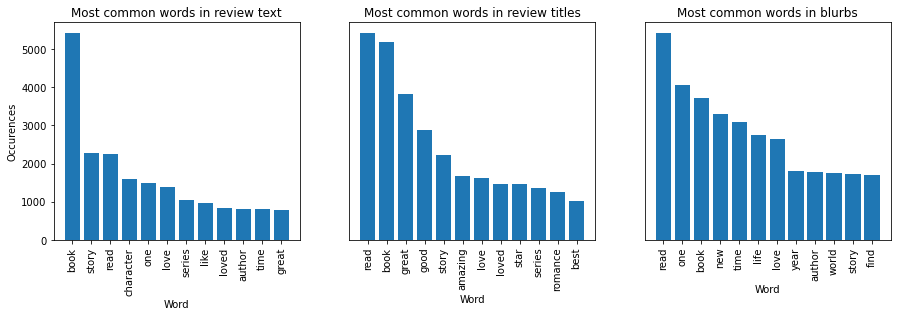

In [399]:
text_data = [text_prep(txt) for txt in df.All_Review_Text]
text_data_2 = [i for i in text_data if i]

title_data = [text_prep(txt) for txt in df.All_Review_Titles]
title_data_2 = [i for i in title_data if i]

blurb_data = [text_prep(txt) for txt in df.Blurb]
blurb_data_2 = [i for i in blurb_data if i]

text_wf = nltk.FreqDist([word for doc in text_data_2 for word in doc]).most_common(12)
text_words = [x[0] for x in text_wf]
text_cnt = [x[1] for x in text_wf]

title_wf = nltk.FreqDist([word for doc in title_data_2 for word in doc]).most_common(12)
title_words = [x[0] for x in title_wf]
title_cnt = [x[1] for x in title_wf]

blurb_wf = nltk.FreqDist([word for doc in blurb_data_2 for word in doc]).most_common(12)
blurb_words = [x[0] for x in blurb_wf]
blurb_cnt = [x[1] for x in blurb_wf]

fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].bar(range(len(text_words)), text_cnt);
ax[0].set_xticks(range(len(text_words)));
ax[0].set_xticklabels(text_words, rotation='vertical');
ax[0].set_title('Most common words in review text');
ax[0].set_xlabel('Word');
ax[0].set_ylabel('Occurences');

ax[1].bar(range(len(title_words)), title_cnt);
ax[1].set_xticks(range(len(title_words)));
ax[1].set_xticklabels(title_words, rotation='vertical');
ax[1].set_title('Most common words in review titles');
ax[1].set_xlabel('Word');
ax[1].set_ylabel('Occurences');
ax[1].set_ylabel("");
ax[1].yaxis.set_ticks_position('none');
ax[1].set_yticklabels('');

ax[2].bar(range(len(blurb_words)), blurb_cnt);
ax[2].set_xticks(range(len(blurb_words)));
ax[2].set_xticklabels(blurb_words, rotation='vertical');
ax[2].set_title('Most common words in blurbs');
ax[2].set_xlabel('Word');
ax[2].set_ylabel('Occurences');
ax[2].set_ylabel("");
ax[2].yaxis.set_ticks_position('none');
ax[2].set_yticklabels('');

plt.show()

### 2.3 Classification of Bestsellers Using Review Text

The first classification model I am running is going to use the text of the reviews and a Naive Bayes classifier. We get an accuracy rate of 81%, but from the confusion matrix we can see that we only accurately predicted a bestseller twice.

Mutinomial Naive Bayes Classification with Review Text Accuracy: 0.8125


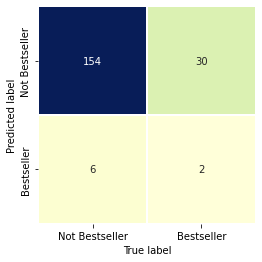

In [400]:
vectorizer = CountVectorizer()
y = df.Bestseller
X = vectorizer.fit_transform([' '.join(token) for token in df.All_Review_Text_Tokens])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=10)

nb_classifier = naive_bayes.MultinomialNB()
nb_classifier.fit(Xtrain,ytrain)
print(f"Mutinomial Naive Bayes Classification with Review Text Accuracy: {np.mean(nb_classifier.predict(Xtest)==ytest)}")

mat = confusion_matrix(ytest, nb_classifier.predict(Xtest))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidths=2, cmap="YlGnBu", 
            yticklabels = ['Not Bestseller', 'Bestseller'],
            xticklabels = ['Not Bestseller', 'Bestseller'])
plt.xlabel('True label')
plt.ylabel('Predicted label');

Next I try a different classifier, a support vector classifier, to much the same results. We again get an accuracy rate of 81%, but this time we only correct predicted a bestseller once. For simplicity in the following steps we use only the Naive Bayes classifier because of it's quick runtime. 

Support Vector Classification with Review Text Accuracy: 0.8125


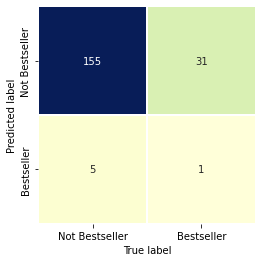

In [177]:
from sklearn.linear_model import SGDClassifier

svc_classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
svc_classifier.fit(Xtrain,ytrain)
print(f"Support Vector Classification with Review Text Accuracy: {np.mean(svc_classifier.predict(Xtest)==ytest)}")

mat = confusion_matrix(ytest, svc_classifier.predict(Xtest))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidths=2, cmap="YlGnBu", 
            yticklabels = ['Not Bestseller', 'Bestseller'],
            xticklabels = ['Not Bestseller', 'Bestseller'])
plt.xlabel('True label')
plt.ylabel('Predicted label');

### 2.3 Classification of Bestsellers Using Alternate Text Variables

I repeat the above process using the other text variables (review title and blurbs). We get a similar accuracy rate from the review titles as we do for the review text, which might be of interest were this analysis to be repeated on a larger dateset as the review tile varible can accomplish similar results with a lot less information. The blurb variables gives a slightly higher accuracy rate of 83% which I did not expect. All the text together achieves the best accuracy rate of 83%. However, I think all of these result don't signify much because a similar (or better) accuracy could be achieved by just always guessing not bestseller. 

In [178]:
#Classification of Review Titles
X2 = vectorizer.fit_transform([' '.join(doc) for doc in title_data_2])
X2train, X2test, y2train, y2test = train_test_split(X2, y, test_size=0.3, random_state=124)

nb_classifier.fit(X2train,y2train)
print(f"Mutinomial Naive Bayes Classification with Review Titles Accuracy: {np.mean(nb_classifier.predict(X2test)==y2test)}")

#Classification with Blurbs
X3 = vectorizer.fit_transform([' '.join(doc) for doc in blurb_data_2])
X3train, X3test, y3train, y3test = train_test_split(X3, y, test_size=0.3, random_state=124)

nb_classifier.fit(X3train,y3train)
print(f"Mutinomial Naive Bayes Classification with Blubs Accuracy: {np.mean(nb_classifier.predict(X3test)==y3test)}")

#Classification with all Text
all_textual_data = [a + b + c for a, b, c in zip(title_data_2, blurb_data_2, text_data_2)]
X4 = vectorizer.fit_transform([' '.join(doc) for doc in all_textual_data])
X4train, X4test, y4train, y4test = train_test_split(X4, y, test_size=0.3, random_state=124)

nb_classifier.fit(X4train,y4train)
print(f"Mutinomial Naive Bayes Classification with All Text Accuracy: {np.mean(nb_classifier.predict(X4test)==y4test)}")

Mutinomial Naive Bayes Classification with Review Titles Accuracy: 0.7916666666666666
Mutinomial Naive Bayes Classification with Blubs Accuracy: 0.828125
Mutinomial Naive Bayes Classification with All Text Accuracy: 0.8333333333333334


## 3. Estimating Daily Sales using Regression Analysis 

In addition to the text variables used in the classification model, I also collected some numerical data from the Amazon listings. In the following sections I am using these variables to estimate daily sales.

In [280]:
#import clean data
df = pd.read_csv('clean_amazon_data.csv', index_col=None, header=0)

#remove rows with missing data
df = df[df["Price"].notna()]
df = df[df["KU"].notna()]
df = df[df["Rating"].notna()]
df = df[df["Customers_Rated"].notna()]
df = df[df["Average_Review_Rating"].notna()]
df = df[df["Rankings"].notna()]

### 3.1 Define Sales Variable

The dependent variable of interest for my regression model is book sales per day. I chose this metric over ranking as a change in rank from \#5000 or \#5500 doesn't mean much substantively, whereas the number of books sold is more tangible. I also suspect that for books with very low popularity, a large change in the rank of the book does not mean much for sales. However, Amazon does not publish the number of books sold. Using the [dubious wisdom of the internet](https://bettermarketing.pub/how-many-kindle-books-do-best-sellers-actually-sell-3ee7c3d48c9b), I have developed a method to reverse engineer the rankings into a estimate of sales. The function get_sales tediously defined below takes the rank of the book and returns an approximation of daily sales.

In [281]:
#Define get sales function
def get_sales(x):
    if x >= 93751:
        return 1
    elif x >= 81251:
        return 2
    elif x >= 68751: 
        return 3 
    elif x >= 56251:
        return 4
    elif x >= 48001: 
        return 5
    elif x >= 44001: 
        return 6 
    elif x >= 40001:
        return 7
    elif x >= 36001:
        return 8
    elif x >= 32001:
        return 9 
    elif x >= 28001:
        return 10
    elif x >= 24001:
        return 11
    elif x >= 20001:
        return 12
    elif x >= 16001:
        return 13
    elif x >= 12001:
        return 14
    elif x >= 9776:
        return 15
    elif x >= 9326:
        return 16
    elif x >= 8876:
        return 17
    elif x >= 8500:
        return 18 
    elif x >= 8000:
        return 19
    elif x >= 7000:
        return 22 
    elif x >= 6000:
        return 24
    elif x >= 5000:
        return 34 
    elif x >= 4000:
        return 52
    elif x >= 3000:
        return 70
    elif x >= 2000:
        return 90 
    elif x >= 1000:
        return 113
    elif x >= 500:
        return 175
    elif x >= 250:
        return 415
    elif x >= 100:
        return 1000
    elif x >= 50:
        return 1758
    elif x >= 20:
        return 3000
    elif x >= 10:
        return 3620
    elif x == 9:
        return 3682
    elif x == 8:
        return 3774
    elif x == 7:
        return 3806
    elif x == 6:
        return 3868
    elif x == 5:
        return 3950
    elif x == 4:
        return 4560
    elif x == 3:
        return 5170
    elif x == 2:
        return 5780
    elif x == 1:
        return 6390
    else:
        return 0

In [282]:
#Create daily sales column in dataframe
df['Daily_Sales'] = df['Rankings'].apply(get_sales).astype(int)

### 3.2 Exploratory Analysis

Before I conduct the regression analysis, I do some quick exploratory analysis of the independent variables. I had a suspicion that I would have a hard time creating a useful model to predict sales because none of the variable I collected appeared to have much differentiation between bestsellers and books with less commercial success. For example there seemed to be as many five star rated books with very low commercial success as there were five star rated best sellers. I have visualized this lack of variation below, using the bestseller dummy used previously. It is pretty clear that our attempts at predicting bestsellers are going to be unsuccessful because the distributions for bestsellers and non-bestsellers are very similar for all variables.

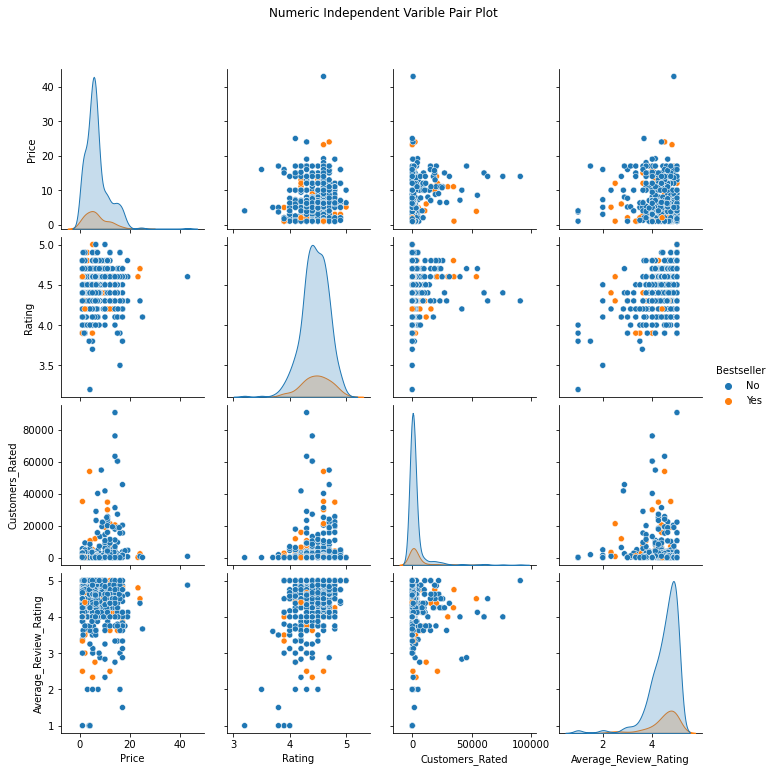

In [383]:
df['Bestseller'] = df['Rankings'].apply(lambda x: 'Yes' if x <= 100 else 'No')

p = sns.pairplot(df[["Price", "Rating", "Customers_Rated", "Average_Review_Rating", "Bestseller"]], 
             hue="Bestseller")

p.fig.suptitle("Numeric Independent Varibles Pair Plot", y=1.07);

### 3.3 Multivariate Linear Regression
Despite the grim outlook, I am going to try and run two regression models anyways.

To start I am doing a simple linear regression with all of my numeric attributes: Price, Kindle Unlimited dummy, Number of customers rated, overall rating, and average top review rating. I get a MSE of 800 thousand, which is not spectacular by any means.

In [225]:
from sklearn import linear_model
X = df[["Price","KU", "Rating", "Customers_Rated", "Average_Review_Rating"]]
y = df['Daily_Sales']

lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

lr_mse = metrics.mean_squared_error(y, lr_model.predict(X))
print(f"Linear Regression on Daily Sales MSE: {lr_mse}")

Linear Regression on Daily Sales MSE: 801067.8956569136


In [221]:
lr_coefs = pd.Series(dict(zip(list(X), lr_model.coef_)))
lr_coefs

Price                      4.556843
KU                        73.162389
Rating                   263.310950
Customers_Rated            0.009864
Average_Review_Rating    -92.286584
dtype: float64

### 3.4 Lasso Regression

I also try using a lasso regression, to much the same, no good, results.

In [224]:
lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

metrics.mean_squared_error(y, lasso_model.predict(X))

801108.5984138127

In [223]:
lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
lasso_coefs

Price                      4.469782
KU                        66.777679
Rating                   236.778646
Customers_Rated            0.009929
Average_Review_Rating    -84.589626
dtype: float64

## 4. Conclusion

The grand conclusion to my efforts is that it is hard to predict what e-books sell better then others based on information listed on Amazon alone. I am not sure that more sophisticated statistical methods would be met with much more success. My suspicion is that the variables I collected just don't have much explanatory power. However, all is not lost because I had a grand time learning to webscrape. Low levels of useful information were acquired but the entertainment value was high. 

## 5. Sources
Sharma, S. K., Chakraborti, S., & Jha, T. (2019). Analysis of book sales prediction at amazon marketplace in india: A machine learning approach. Information Systems and eBusiness Management, 17(2-4), 261-284. doi:http://dx.doi.org/10.1007/s10257-019-00438-3
